# A sparsely connected recurrent network

A model of activity dynamics in a local cortical network proposed by Brunel (2000). The Notebook is inspired by [this one](https://notebook.community/mschmidt87/nest-simulator/doc/nest_by_example/NEST_by_Example).

**1. Neuron populations**:

The local cortical network consists of two neuron populations: 
* a population of $N_E$ excitatory neurons 
* and a population of $N_I$ inhibitory neurons. 
To mimic the cortical ratio of 80% excitatory neurons and 20% inhibitory neurons, we assume that $N_E=$ 8000 and $N_I=$ 2000. Thus, our local network has a total of 10,000 neurons.

**2. Neuron model**:

For both the excitatory and the inhibitory population, we use the same integrate-and-fire neuron model with current-based synapses. 
* Incoming excitatory and inhibitory spikes displace the membrane potential $V_m$ by $J_{E}$ and $J_I$, respectively. 
* If $V_m$ reaches the threshold value $V_{\text{th}}$, the membrane potential is reset to $V_{\text{reset}}$, a spike is sent with delay $D=$ 1.5 ms to all post-synaptic neurons, and the neuron remains refractory for $\tau_{\text{rp}}=$ 2.0 ms.

**3. Neuron conections**:

The neurons are mutually connected with a probability of 10%. Specifically, each neuron receives input from 
* $C_{E}= 0.1 \cdot N_{E}$ excitatory and 
* $C_I=0.1\cdot N_{I}$ inhibitory neurons. 
The inhibitory synaptic weights $J_I$ are chosen with respect to the excitatory synaptic weights $J_E$ such that $J_I = -g \cdot J_E$, with $g=$ 5.0 in this example.

**4. External Stimulation**: 

In addition to the sparse recurrent inputs from within the local network, each neuron receives randomly timed excitatory input, mimicking the input from the rest of cortex. The random input is modelled as $C_E$ independent and identically distributed Poisson processes with rate $\nu_{\text{ext}}$, or equivalently, by a single Poisson process with rate $C_E \cdot \nu_{\text{ext}}$. Here, we set $\nu_{\text{ext}}$ to twice the rate $\nu_{\text{th}}$ that is needed to drive a neuron to threshold asymptotically. The details of the model are summarized in the tables below.

**5. Expected results**:

In the resulting plot you should see a raster plot of 50 excitatory neurons during the first 300 ms of simulated time. Time is shown along the x-axis, neuron ID along the y-axis. At $t=0$, all neurons are in the same state $V_m=0$ and hence there is no spiking activity. The external stimulus rapidly drives the membrane potentials towards the threshold. 

Due to the random nature of the external stimulus, not all the neurons reach the threshold at the same time. After a few milliseconds, the neurons start to spike irregularly at roughly 40 spikes/s. In the original paper, this network state is called the asynchronous irregular state (Brunel, 2000).

### Plot configuration

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import scienceplots

plt.style.use(["science"])

### 1. Initializing the network

**Model parameters**

In [1]:
g = 5.0  # Ratio of IPSP to EPSP amplitude: J_I/J_E
eta = 2.0  # rate of external population in multiples of threshold rate
delay = 1.5  # synaptic delay in ms
tau_m = 20.0  # Membrane time constant in mV
V_th = 20.0  # Spike threshold in mV

N_E = 8000
N_I = 2000
N_neurons = N_E + N_I

C_E = int(N_E / 10)  # number of excitatory synapses per neuron
C_I = int(N_I / 10)  # number of inhibitory synapses per neuron

J_E = 0.1
J_I = -g * J_E

nu_ex = eta * V_th / (J_E * C_E * tau_m)  # rate of an external neuron in ms^-1
p_rate = 1000.0 * nu_ex * C_E  # rate of the external population in s^-1

In the second to last line, we compute the firing rate nu_ex ($\nu*{\text{ext}}$) of a neuron in the external population. We define nu_ex as the product of a constant eta times the threshold rate $\nu_{\text{th}}$, i.e. the steady state firing rate which is needed to bring a neuron to threshold. The value of the scaling constant is defined with eta.

In the final line, we compute the combined input rate due to the external population. With $C_E$ incoming synapses per neuron, the total rate is simply the product nu_ex\*C_E. The factor 1000.0 in the product changes the units from spikes per ms to spikes per second.


In [12]:
import nest
import nest.raster_plot
import pylab

nest.ResetKernel()
n = 4  # number of threads
nest.SetKernelStatus({'local_num_threads': n})

nest.SetKernelStatus({"print_time": True})

**Create neurons and devices**

The parameter values comes from Brunel's original paper

In [13]:
nest.SetDefaults(
    "iaf_psc_delta",
    {
        "C_m": 1.0,
        "tau_m": tau_m,
        "t_ref": 2.0,
        "E_L": 0.0,
        "V_th": V_th,
        "V_reset": 10.0,
    },
)

In [14]:
nodes = nest.Create("iaf_psc_delta", N_neurons)
nodes_E = nodes[:N_E]
nodes_I = nodes[N_E:]

noise = nest.Create("poisson_generator", 1, {"rate": p_rate, "start": 0, "stop": 200})
nest.SetDefaults("spike_recorder", {"to_file": True})

spikes = nest.Create(
    "spike_recorder", 2, [{"label": "brunel-py-ex"}, {"label": "brunel-py-in"}]
)

spikes_E = spikes[:1]
spikes_I = spikes[1:]

**Conecting the network**

In [15]:
nest.CopyModel(
    "static_synapse_hom_w",
    "excitatory",
    {
        "weight": J_E,
        "delay": delay,
    },
)
nest.Connect(
    nodes_E,
    nodes,
    {"rule": "fixed_indegree", "indegree": C_E},
    "excitatory",
)
nest.CopyModel(
    "static_synapse_hom_w",
    "inhibitory",
    {
        "weight": J_I,
        "delay": delay,
    },
)
nest.Connect(
    nodes_I,
    nodes,
    {"rule": "fixed_indegree", "indegree": C_I},
    "inhibitory",
)

In [16]:
nest.Connect(noise, nodes, syn_spec="excitatory")

Our network consists of 10,000 neurons, all of which have the same activity statistics due to the random connectivity. Thus, it suffices to record from a representative sample of neurons, rather than from the entire network. 

Here, we choose to record from 50 neurons and assign this number to the variable N_rec. We then connect the first 50 excitatory neurons to their spike detector. Again, we use standard Python list operations to select N_rec neurons from the list of all excitatory nodes. Alternatively, we could select 50 neurons at random, but since the neuron order has no meaning in this model, the two approaches would yield qualitatively the same results. Finally, we repeat this step for the inhibitory neurons.

In [17]:
N_rec = 50
nest.Connect(nodes_E[:N_rec], spikes_E)
nest.Connect(nodes_I[:N_rec], spikes_I)

## 2. Simulating the network


Mar 30 11:08:55 NodeManager::prepare_nodes [Info]: 
    Preparing 10012 nodes for simulation.
Excitatory rate: 12.33 Hz
Inhibitory rate: 12.30 Hz

Mar 30 11:08:55 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 10012
    Simulation time (ms): 600
    Number of OpenMP threads: 4
    Number of MPI processes: 1

[ 100% ] Model time: 600.0 ms, Real-time factor: 2.5604

Mar 30 11:08:57 SimulationManager::run [Info]: 
    Simulation finished.


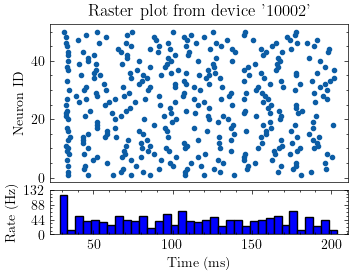

In [18]:
simtime = 600
nest.Simulate(simtime)
ex_events, in_events = nest.GetStatus(spikes, "n_events")
events_to_rate = 1000.0 / simtime / N_rec

rate_ex = ex_events * events_to_rate
print("Excitatory rate: {:.2f} Hz".format(rate_ex))

rate_in = in_events * events_to_rate
print("Inhibitory rate: {:.2f} Hz".format(rate_in))

nest.raster_plot.from_device(spikes_E, hist=True)


## 3. Parallel simulation